## Домашняя работа 4. 

Максимальный балл за задание - 10.

Выполнил: Тихонов Сергей, БЭК-181

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [126]:
from matplotlib import pylab as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
    from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
from time import time
#%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [135]:
df = pd.read_csv('data.adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [136]:
# Для начала посмотрим, сколько всего пропущенных значений и каким признакам они характерны

df.replace("?", np.nan, inplace=True)
df.isna().sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [137]:
# Удалим эти объекты

df.dropna(axis=0, inplace=True)
df.reset_index(inplace=True)
df.isna().sum()

index             0
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64

**Промежуточный вывод**: пропущенные значения удалены.

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [138]:
df.columns = df.columns.str.replace('>50K,<=50K', 'target')
df.drop('index', axis=1, inplace=True)

X = df.iloc[:,:-1]
num = X.columns[X.dtypes == 'int64'].tolist()
X_num = X[num].copy()

y = (df.target == '<=50K').astype('int')

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [6]:
# https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python - красивый доверительный
# интервал в питоне взял отсюда.

def calc_params(X, y, model, param_name, param_values, need_plot=True):
    
    grid = GridSearchCV(model,
            {param_name: param_values},
            scoring='roc_auc',
            cv = 5
            )
    
    grid.fit(X, y)
    
    mean = grid.cv_results_.get("mean_test_score")
    std = grid.cv_results_.get("std_test_score")
    
    if need_plot:
        
        bottom_bonder = mean - std 
        upper_bonder = mean + std 
        
        plt.figure(figsize=(18, 10))
        plt.grid(b=1)
        plt.plot(param_values, mean, color = 'crimson')
        plt.plot(param_values, bottom_bonder, color = 'darkcyan')
        plt.plot(param_values, upper_bonder, color = 'darkcyan')
        plt.fill_between(param_values, bottom_bonder, upper_bonder, facecolor='darkcyan', alpha=0.2)
        plt.xlabel(param_name)
        plt.ylabel('CV score')
        plt.show()
    
    return grid.best_params_

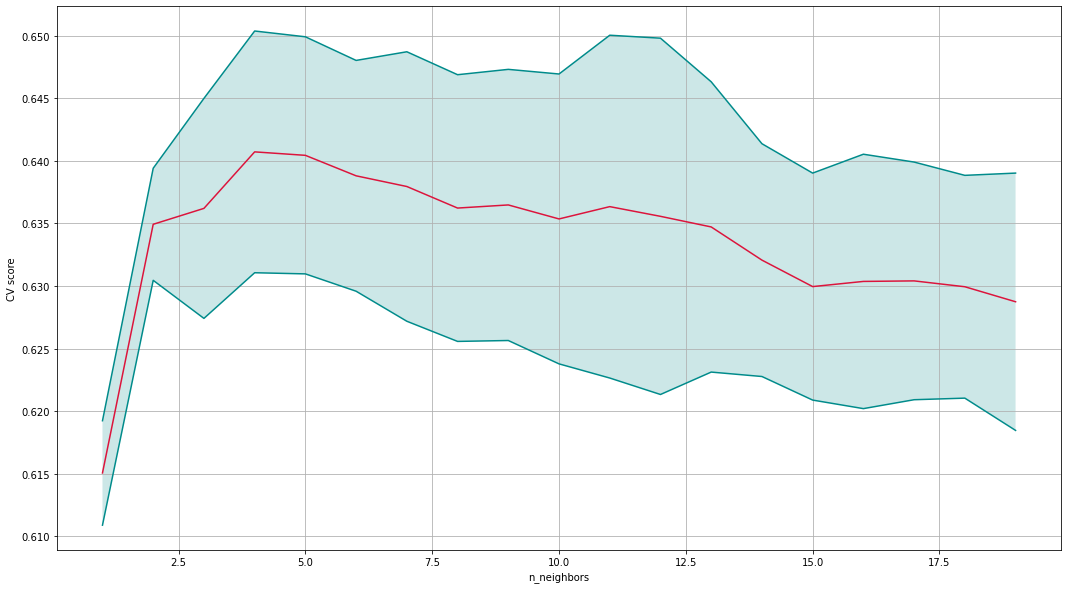

{'n_neighbors': 4}

In [7]:
calc_params(X_num, y, KNeighborsClassifier(), 'n_neighbors', np.arange(1, 20, 1))

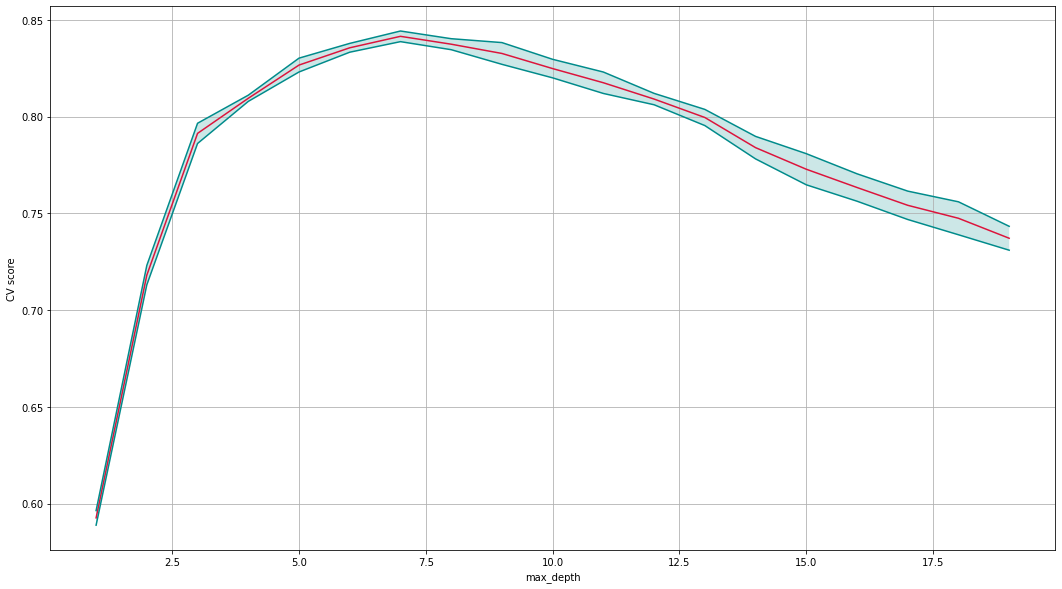

{'max_depth': 7}

In [8]:
calc_params(X_num, y, DecisionTreeClassifier(), 'max_depth', np.arange(1, 20, 1))

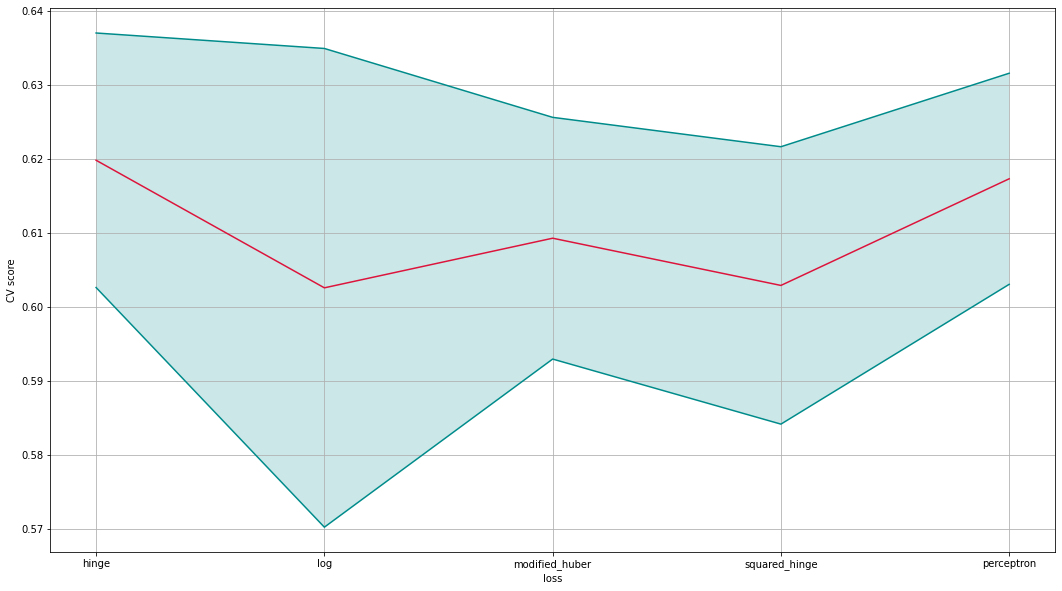

{'loss': 'hinge'}

In [9]:
calc_params(X_num, y, SGDClassifier(), 'loss', ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'])

Что вы можете сказать о получившихся графиках?

1. KNN

Для данного алгоритма мы видим параболическую зависимость от числа соседей: сначала она растёт поскольку при малом числе соседей низкая обобщаяющая способность, при очень большом числе соседей - ответ даётся уже не по ближайшим соседям, а по некоторому среднему значению. При этом стоить заметить, что разброс модели довольно высокий (особенно относительно других моделей).

2. DecesionTree

Для данного алгоритма характерна аналогичная зависимость, то есть при низкой глубине деревья очень недообучены, тогда как при высокой - становятся переобченными. Стоит заметить как растёт разброс модели - с ростом глубины ширина дерева растёт.

3. SGDClassifier

Выбран loss hinge (функционал ошибки эквивалентный методу опорных векторов). Показал лучшее качество, при этом разброс вполне сопостовимый с другими моделями.



**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

In [41]:
def RF_optimum(X_train, X_val, y_train, y_val, n_trees):

    ranfor = RandomForestClassifier(n_estimators=n_trees)
    ranfor.fit(X_train, y_train)

    y_pred = np.zeros((n_trees, X_val.shape[0]))
    roc_auc = np.zeros(n_trees)

    for i in range(n_trees):
        
        y_pred[i] = ranfor.estimators_[i].predict_proba(X_val)[:,1]
        probs = np.mean(y_pred[:i+1], axis=0)
        roc_auc[i] = roc_auc_score(y_val, probs)
    
    return roc_auc

In [42]:
def cross_v(X_num, y, n_trees, eta, need_plot=True):
    
    kf = KFold(n_splits = 5)
    roc_auc = []
    
    for train_index, val_index in kf.split(X_num):
        
        X_train, X_val = X_num.iloc[train_index], X_num.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        roc_auc.append(RF_optimum(X_train, X_val, y_train, y_val, n_trees))
    
    full_roc_auc = np.mean(roc_auc, axis=0)
    diff = np.diff(full_roc_auc)
    tiny_diff = diff[np.abs(diff) < eta][0]

    optim_number_of_trees, = np.where(diff == tiny_diff)[0]
    print(f'ROC-AUC стабилизируется после достижения {optim_number_of_trees} деревьев и составляет {full_roc_auc[optim_number_of_trees-1]}')
    
    if need_plot:
        
        plt.figure(figsize=(18, 10))
        plt.grid(b=1)
        plt.plot(np.arange(n_trees), full_roc_auc, color = 'crimson')
        plt.xlabel('n_trees')
        plt.ylabel('CV score')
        plt.show()

ROC-AUC стабилизируется после достижения 108 деревьев и составляет 0.8158574635881252


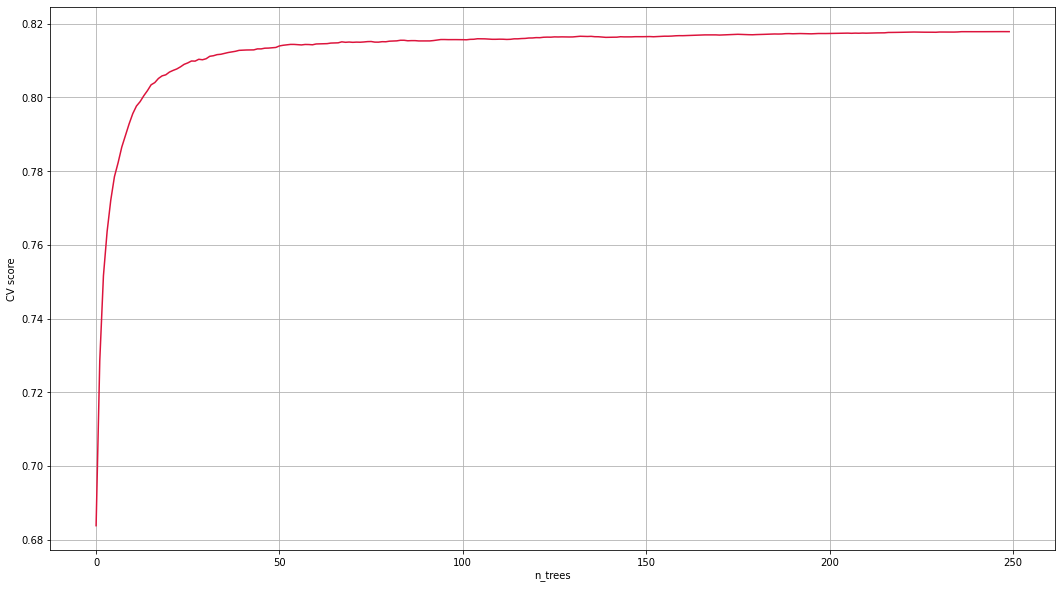

In [43]:
cross_v(X_num, y, n_trees=250, eta=1e-6)

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

Продолжим мерить именно score (auc-roc), а не ошибку, так как в начале работы сказано работать именно с ним.

In [332]:
def cv_GB_optimum(X, y, need_plot=True):

    roc_auc = []

    for n_trees in range(5, 1000, 20):
        
        gradboost = GradientBoostingClassifier(n_estimators=n_trees)
        cv_res = cross_val_score(gradboost, X, y, cv=5, scoring='roc_auc')
        roc_auc.append(cv_res.mean())
    
    optim_number_of_trees = np.argmax(roc_auc) * 20 + 5
    max_roc_auc = np.max(roc_auc)
    print(f'ROC-AUC достигает максимума после достижения {optim_number_of_trees} деревьев и составляет {max_roc_auc}')
    
    if need_plot:
        
        plt.figure(figsize=(18, 10))
        plt.grid(b=1)
        plt.plot(np.arange(5, 1000, 20), roc_auc, color = 'crimson')
        plt.xlabel('n_trees')
        plt.ylabel('CV score')
        plt.show()

ROC-AUC достигает максимума после достижения 305 деревьев и составляет 0.8659137349664752


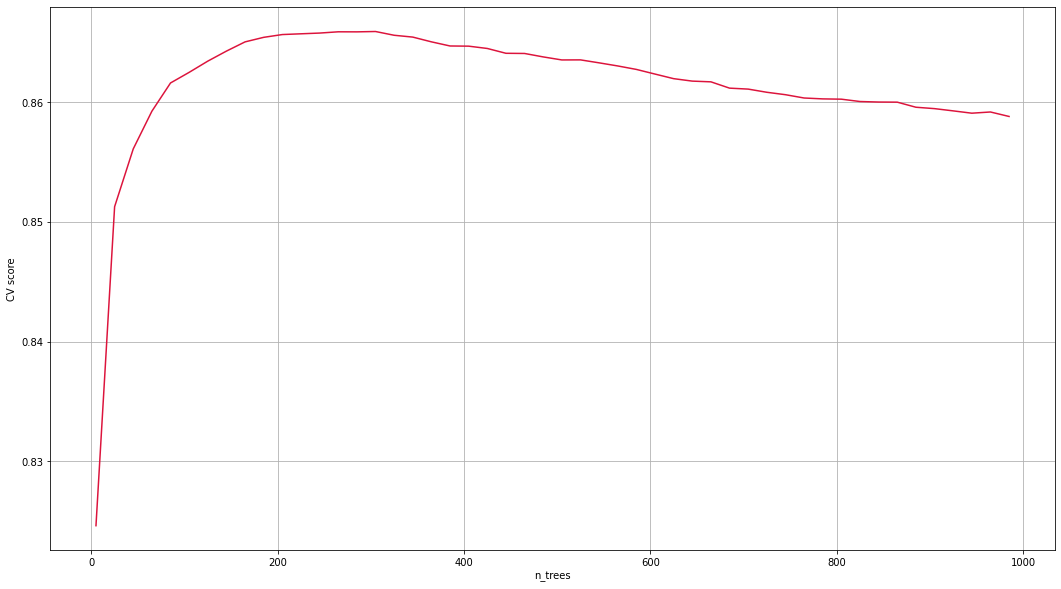

In [333]:
cv_GB_optimum(X_num, y)

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

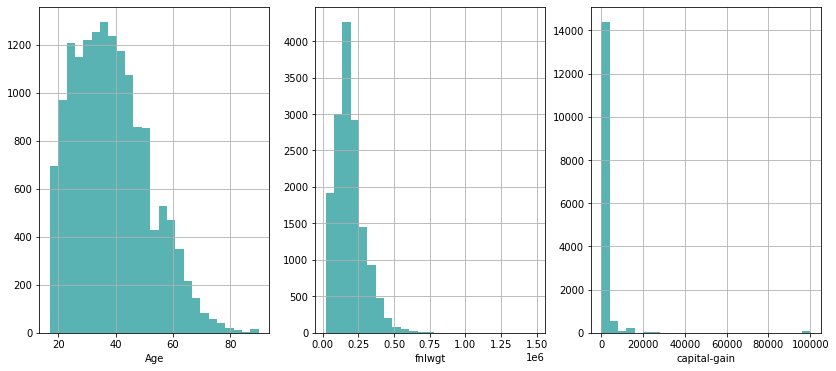

In [203]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6)) 

ax[0].hist(X_num['age'], alpha = 0.65, bins=25, color = 'darkcyan', label='Age')
ax[0].set_xlabel('Age')
ax[0].grid(b=1)

ax[1].hist(X_num['fnlwgt'], alpha = 0.65, bins=25, color = 'darkcyan', label='fnlwgt')
ax[1].set_xlabel('fnlwgt')
ax[1].grid(b=1)

ax[2].hist(X_num['capital-gain'], alpha = 0.65, bins=25, color = 'darkcyan', label='capital-gain')
ax[2].set_xlabel('capital-gain')
ax[2].grid(b=1);

**Промежуточный вывод**: в данных есть несколько особенностей:

1) Сильно различается масштаб данных 

2) Сильно различается разброс данных 

3) Распределения в целом тоже различаются

Масштабирование может повлиять на работу алгоритмов, так как некоторые из них (линейная модель и KNN) чувствительны к масштабу данных.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

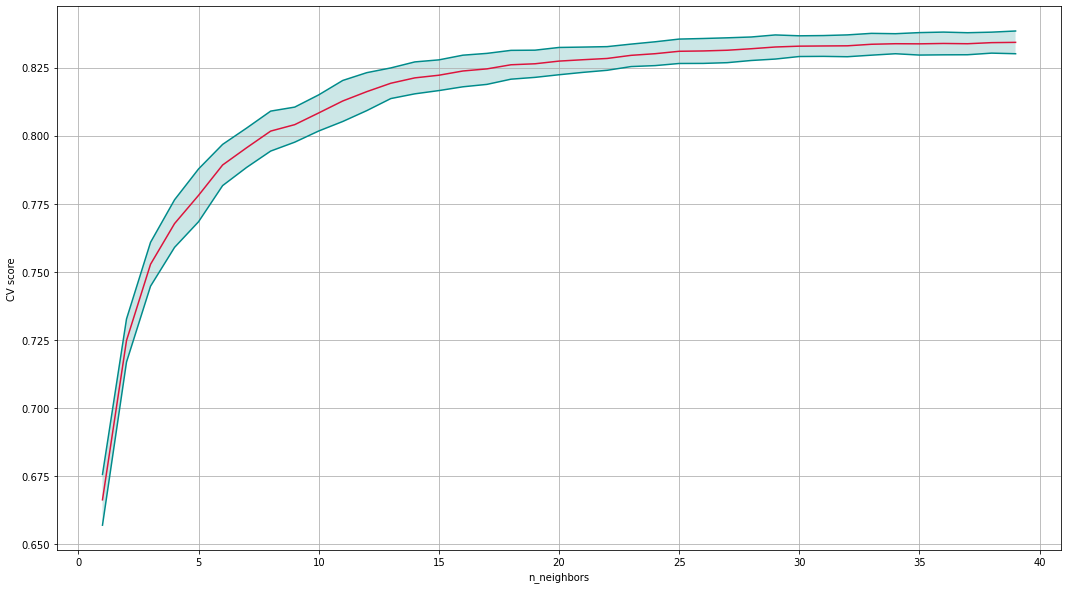

{'n_neighbors': 39}

In [204]:
calc_params(X_num_scaled, y, KNeighborsClassifier(), 'n_neighbors', np.arange(1, 40, 1))

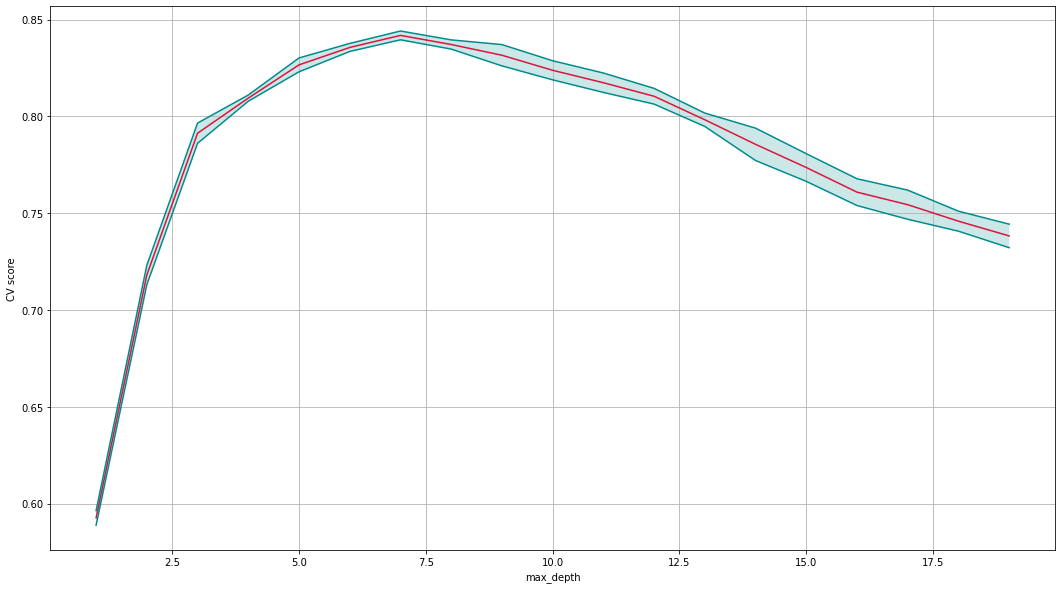

{'max_depth': 7}

In [205]:
calc_params(X_num_scaled, y, DecisionTreeClassifier(), 'max_depth', np.arange(1, 20, 1))

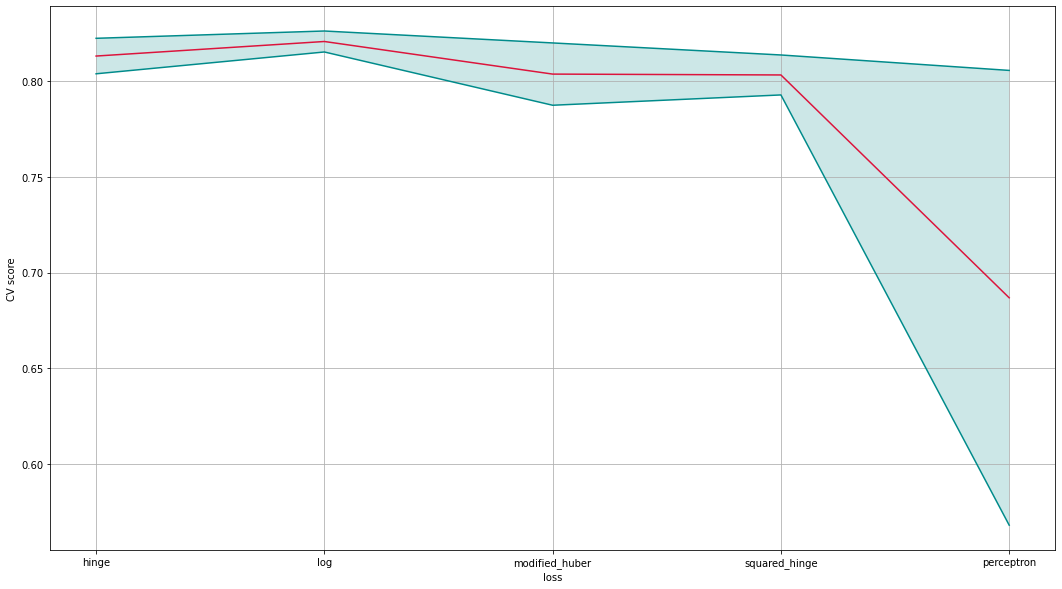

{'loss': 'log'}

In [206]:
calc_params(X_num_scaled, y, SGDClassifier(), 'loss', ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'])

Изменилось ли качество у некоторых алгоритмов?

Как и описывалось выше, качество у алгоритмов изменилось, но не у всех:

**KNN**:

Качество этого алгоритма крайне чувствительно к масштабированию, поскольку такова специфика поиска ближайших соседей: расстояние между разными признаками (например, признак А измеряется в диапозоне от 0 до 1, а признак Б в диапозоне от 1000 до 5000) сильно зависит от признаков с большими диапозонами, поскольку при расчёте расстояний до ближайших соседей именно они будут вносить существенный вклад. Когда мы проводим нормализацию, все признаки переводятся в определенный диапозон (обычно от 0 до 1), в результате этой проблемы нет.

**DecisionTree**:

Масштабирование не влияет на качество работы решающих деревьев, поскольку принцип построения решающего дерева основан на выборе предикатов (комбинации **j** и **t**, такой что неоднородность **H(R)** в левой и правой вершине после разбиения была минимальна). Поскольку признак **j** выбирается в каждой вершине один, то предикат **t** (тоже единственный в данной вершине) просто подбирается в нужном диапозоне признака **j**, другие признаки на него не влияют.

**SGD Classifier**:

Тут сложнее. В первую очередь коэффициенты могут стать интерпретируемыми (при увеличении признака $x_i$ на 1 таргет изменится на $\beta$). Но есть некоторый момент, связанный с $l1$ и $l2$ регуляризацией (которая по дефолту есть): коэффициенты признаков с большой дисперсией меньше штрафуются регуляризацией.
 
**Gradient Boosting и Random Forest**:
Эти алгоритмы представляют собой ансамблирование **DecisionTree**, поэтому они также не чувствительны к масштабу.

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

**Методология**: для разных алгоритмов попробуем разные "опмтимизации" подбора параметров. 

1. В случае с KNN, попробуем (1) способ, а именно сделать сетку разреженной, поскольку в случае метрики достаточно рассмотреть два случая - манхетенскую (сумму модулей), евклидову (корень из суммы квадратов), а часть соседей можно пропустить

2. В случае решающего дерева, можно воспользоваться классической KFold кроссвалидацией, поскольку существует всего два возможных критерия - gini и entropy, а часть соседей можно пропустить

3. В случае с RandomForest, аналогично предыдущим, попробуем сделать перебором по сетке GridSearch

4. GradientBoosting - вычислительно затратный алгоритм, будем выбирать гиперпараметры жадно, сетку сделаем более разреженной, а еще сделаем меньше разбиений (то есть воспользуемся сразу трёмя советами)

5. Для логистической регрессии попробуем обучить жадно: сначала выберем оптимальный loss, а затем для него подберем оптимальный penalty.

In [217]:
# Идея: для разных алгоритмов попробуем разные "опмтимизации" подбора параметров. 

model = KNeighborsClassifier()
start = time()
grid_knn = GridSearchCV(model,
        {'n_neighbors': np.arange(1, 20, 1),
        'metric': ['euclidean', 'manhattan']},
        scoring='roc_auc',
        cv = 5
        )
    
grid_knn.fit(X_num, y)
end = time()
print(f'Лучшие параметры для KNN: {grid_knn.best_params_}')
print(f'Время кросс-валидации KNN: {end - start} секунд')

Лучшие параметры для KNN: {'metric': 'manhattan', 'n_neighbors': 4}
Время кросс-валидации KNN: 8.47308874130249 секунд


In [218]:
model = DecisionTreeClassifier()
start = time()
grid_tree = GridSearchCV(model,
        {'max_depth': np.arange(1, 20, 1),
        'criterion': ['gini', 'entropy']},
        scoring='roc_auc',
        cv = 5
        )
    
grid_tree.fit(X_num, y)
end = time()
print(f'Лучшие параметры для решающего дерева: {grid_tree.best_params_}')
print(f'Время кросс-валидации решающего дерева: {end - start} секунд')

Лучшие параметры для решающего дерева: {'criterion': 'entropy', 'max_depth': 8}
Время кросс-валидации решающего дерева: 4.746233224868774 секунд


In [312]:
model = RandomForestClassifier(n_estimators=108)
start = time()
grid_rf = GridSearchCV(model,
        {'criterion': ['gini', 'entropy'],
         'max_features': ['log2', 'sqrt']}, 
        scoring='roc_auc',
        cv = 5
        ) 
    
grid_rf.fit(X_num, y)
end = time()
print(f'Лучшие параметры для случайного леса: {grid_rf.best_params_}')
print(f'Время кросс-валидации случайного леса: {end - start} секунд')

Лучшие параметры для случайного леса: {'criterion': 'entropy', 'max_features': 'sqrt'}
Время кросс-валидации случайного леса: 27.593996047973633 секунд


In [315]:
model = GradientBoostingClassifier(n_estimators=300)
start = time()
grid1 = GridSearchCV(model,
        {'criterion': ['friedman_mse', 'mae']}, 
        scoring='roc_auc',
        cv = 3
        ) 
    
grid1.fit(X_num, y)

model = GradientBoostingClassifier(n_estimators=300, criterion = grid1.best_params_.get('criterion'))
grid_gb = GridSearchCV(model,
         {'max_features': ['log2', 'sqrt']}, 
        scoring='roc_auc',
        cv = 3
        ) 
    
grid_gb.fit(X_num, y)

end = time()
print(f'Лучшие параметры для градиентного бустинга: {grid1.best_params_, grid_gb.best_params_}')
print(f'Время кросс-валидации градиентного бустинга: {end - start} секунд')

Лучшие параметры для градиентного бустинга: ({'criterion': 'friedman_mse'}, {'max_features': 'log2'})
Время кросс-валидации градиентного бустинга: 1260.016088962555 секунд


In [220]:
model = SGDClassifier()
start = time()
grid_lr = GridSearchCV(model,
        {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
         'penalty': ['l1', 'l2', 'elasticnet']}, 
        scoring='roc_auc',
        cv = 5
        ) 
    
grid_lr.fit(X_num, y)
end = time()
print(f'Лучшие параметры для логистической регрессии: {grid_lr.best_params_}')
print(f'Время кросс-валидации логистической регрессии: {end - start} секунд')

Лучшие параметры для логистической регрессии: {'loss': 'modified_huber', 'penalty': 'l1'}
Время кросс-валидации логистической регрессии: 10.628326892852783 секунд


Какой из алгоритмов имеет наилучшее качество? 

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

**Сравнение времени обучения на кросс-валидации выполнено в предыдущем задании, в данном разделе подведём итоги**:

Очевидно, что больше всего времени ушло на обучение **GradientBoostClassifier**, поскольку данная модель и **RandomForestClassifier** представляют собой ансамблированные методы (состоящие из 200 и 108 деревьев соответственно), что, очевидно, обучается дольше, чем отдельные базовые модели. 

Сравниваия ансамбли между собой, стоит отметить, что **RandomForestClassifier** фактически может обучаться **параллельно**: достаточно обучить 108 деревьев и провести голосование за самый популярный класс (в случае задачи классификации). Тогда как в случае **GradientBoostClassifier** необходимо обучать 200 деревьев **последовательно**: на основе первого дерева обучается второе, на основе первого и второго обучается третье и тд. В результате, **GradientBoostClassifier** обучается дольше, но при этом ценится за высокое качество.

Результаты: **GB** = 1260 секунд vs. **RF** = 53 секунд

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [139]:
X = pd.get_dummies(X, ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                       'race', 'sex'], drop_first=True)

scaler = StandardScaler()
X[num] = scaler.fit_transform(X[num])

# Масштабированные вещественные и закодированные категориальные признаки:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,-0.342919,0.900258,-0.450788,-0.065600,-0.21874,1.588223,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0.114760,0.010683,-0.059086,-0.150439,-0.21874,-0.074178,0,1,0,0,...,1,0,0,0,0,0,0,0,1,1
2,-0.190359,-0.106280,1.116020,-0.150439,-0.21874,-0.074178,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.21874,-0.905379,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0.648719,-0.371197,1.116020,1.995391,-0.21874,-0.074178,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [251]:
models = [('KNN', KNeighborsClassifier(n_neighbors=4, metric='manhattan')), 
          ('DecisionTree', DecisionTreeClassifier(max_depth=8, criterion='entropy')),
          ('RandomForest', RandomForestClassifier(n_estimators=108, criterion='entropy', max_features=None)),
          ('GradientBoosting', GradientBoostingClassifier(n_estimators=300, criterion='friedman_mse', max_features=None)),
          ('SGDClassifier', SGDClassifier(loss='squared_hinge', penalty='l1'))]

for model in models:
    score = cross_val_score(model[1], X, y, cv=5, scoring='roc_auc')
    print(f'Качество модели {model[0]} на кросс-валидации с 5 фолдами: {score.mean()}\n')

Качество модели KNN на кросс-валидации с 5 фолдами: 0.8440717170135736

Качество модели DecisionTree на кросс-валидации с 5 фолдами: 0.8903433913790033

Качество модели RandomForest на кросс-валидации с 5 фолдами: 0.9015967801363427

Качество модели GradientBoosting на кросс-валидации с 5 фолдами: 0.9177499543719435

Качество модели SGDClassifier на кросс-валидации с 5 фолдами: 0.8389156798021048



Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Нет, **GradientBoosting** как показывал лучший результат, так и показывает (его преимущества описаны выше).

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [124]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_withpoly = poly.fit_transform(X[num])

In [172]:
# Для задач выше будем использовать Decision Tree, поскольку быстрее чем ансамбли и при этом демонстрирует высокое качество, 
# а также удобно, что из гиперпараметров можно подбирать только глубину (остальное не особо влияет)

# Также в этом номере я позволю себе снизить cv = 3, поскольку даже для нижеописанного случая мы обучаем 45 алгоритмов - что 
# очень долго.

from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.pipeline import Pipeline

clf1 = Pipeline([('filter', SelectKBest(score_func=mutual_info_classif)), 
                ('Tree', DecisionTreeClassifier())])
grid_a = GridSearchCV(clf1, {'filter__k': [5, 10, 15, 20, 25], 'Tree__max_depth': [5, 7, 9]},
                      scoring = 'roc_auc', cv = 3)
grid_a.fit(X_withpoly, y)

print(f'Оптимальная глубина дерева и оптимальное количество признаков {grid_a.best_params_}')
X_full = np.concatenate((X_withpoly, np.array(X[X.columns[6:]])), axis=1)
print(f'Итоговое качество: {cross_val_score(grid_a.best_estimator_, X_full, y, cv=3).mean()}')


Оптимальная глубина дерева и оптимальное количество признаков {'Tree__max_depth': 7, 'filter__k': 5}
Итоговое качество: 0.8480486216040707


In [183]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

clf2 = Pipeline([('filter', RFE(LogisticRegression(max_iter=1000), step=12)), 
                ('Tree', DecisionTreeClassifier())])
grid_b = GridSearchCV(clf2, {'filter__n_features_to_select': [5, 10, 12, 15, 17, 20, 25, 35], 
                             'Tree__max_depth': [5, 7, 9]},
                      scoring = 'roc_auc', cv = 3)
grid_b.fit(X_withpoly, y)

print(f'Оптимальная глубина дерева и оптимальное количество признаков {grid_b.best_params_}')
print(f'Итоговое качество: {cross_val_score(grid_b.best_estimator_, X_full, y, cv=3).mean()}')


Оптимальная глубина дерева и оптимальное количество признаков {'Tree__max_depth': 7, 'filter__n_features_to_select': 15}
Итоговое качество: 0.8451158027856053


In [216]:
from sklearn.feature_selection import SelectFromModel

# Тут количество финальных признаков подбирается в соответствии с обученной лог регрессией
clf3 = Pipeline([('filter', SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), 
                                  threshold=1e-5)), 
                ('Tree', DecisionTreeClassifier())])
grid_c = GridSearchCV(clf3, {'filter__estimator__C': [0.1, 0.5, 1, 1.5, 2],'Tree__max_depth': [3, 5, 7, 9, 11]},
                      scoring = 'roc_auc', cv = 3)
grid_c.fit(X_withpoly, y)

print(f'Оптимальная глубина дерева и оптимальное количество признаков {grid_c.best_params_}')
print(f'Итоговое качество: {cross_val_score(grid_c.best_estimator_, X_full, y, cv=3).mean()}')


Оптимальная глубина дерева и оптимальное количество признаков {'Tree__max_depth': 7, 'filter__estimator__C': 0.5}
Итоговое качество: 0.8396431209112487


**Промежуточный вывод**: Качество немного снизилось, возможно из-за того, что полиномы вещественных признаков не особо помогают предсказывать таргет, а скорее даже зашумляют его. При этом я также пробовал исследовать другие классификаторы (кроме ансамблей, слишком долго работают на кросс-валидации): нигде не получилось получить более высокие результаты.

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

**План**: буду продолжать работать без полиномиальных признаков, потому что ощутимого прироста в качестве они не дали.

In [316]:
def stacking(X, y, model1, model2, need_plot=True):
    
    kf = KFold(n_splits = 5)
    alphas = np.arange(0, 1.1, 0.1)
    roc_auc_full = []
    
    
    for alpha in alphas:
        
        auc_roc = []
        for train_index, val_index in kf.split(X):
        
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            model1.fit(X_train, y_train)
            model2.fit(X_train, y_train)
            
            proba1 = model1.predict_proba(X_val)[:,1]
            proba2 = model2.predict_proba(X_val)[:,1]
            
            probs = alpha * proba1 + (1-alpha) * proba2
            auc_roc.append(roc_auc_score(y_val, probs))
        

        roc_auc_full.append(np.mean(auc_roc))
    
    if need_plot:
        
        plt.figure(figsize=(18, 10))
        plt.grid(b=1)
        plt.plot(alphas, roc_auc_full, color = 'crimson')
        plt.xlabel('alphas')
        plt.ylabel('CV score')
        plt.show()

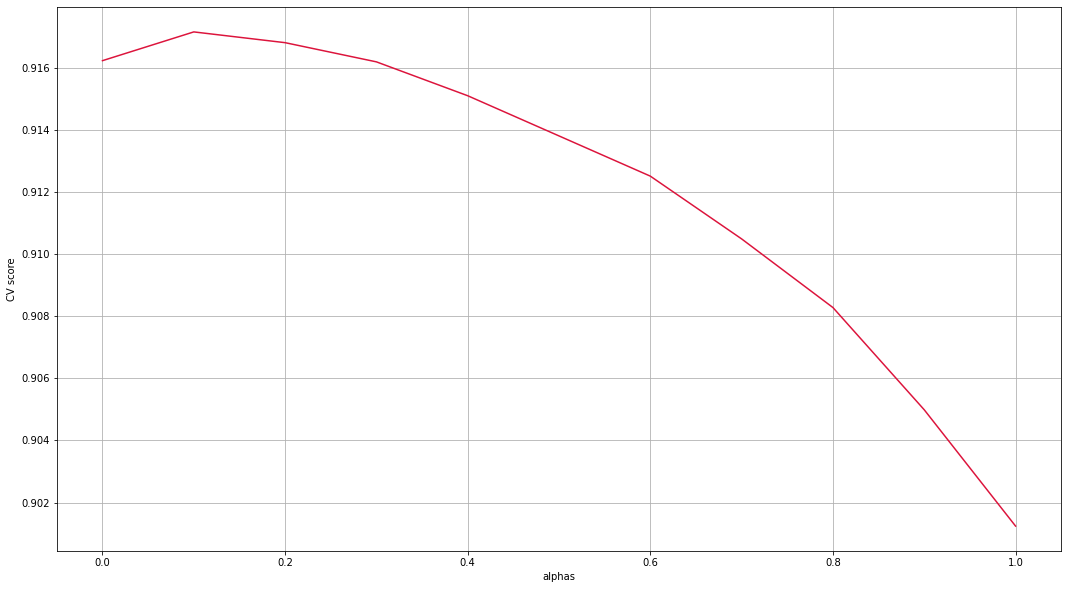

In [317]:
# RF - 1 estimator, GB - 2 estimator
stacking(X, y, grid_rf.best_estimator_, grid_gb.best_estimator_)

In [318]:
# Получим AUC-ROC на CV с оптимальным alpha

kf = KFold(n_splits = 5)
alpha_optim = 0.1
scores_stack = []

for train_index, val_index in kf.split(X):
        
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
            
        grid_rf.best_estimator_.fit(X_train, y_train)
        grid_gb.best_estimator_.fit(X_train, y_train)
        
        proba1 = grid_rf.best_estimator_.predict_proba(X_val)[:,1]
        proba2 = grid_gb.best_estimator_.predict_proba(X_val)[:,1]
            
        probs = alpha_optim * proba1 + (1-alpha_optim) * proba2
        scores_stack.append(roc_auc_score(y_val, probs))

**Промежуточный вывод**: по сути мы получили факт, что **градиентный бустинг** лучше **случайного леса**, поскольку оптимальное качество (по score roc-auc) достигается при **alpha=0**, то есть в случае, когда случайный лес идёт с весом 0 и берётся предсказание бустинга. Но ради актуальности стекинга в дальнейших пунктах, возьмем **alpha = 0.1**, чтобы можно было сравнивать с другими алгоритмами.

Возможно, стоило рассматривать разные по природе модели (GB и RF основаны на решающих деревьях), и тогда возможно было бы получить какое-то осмысленное решение, но в задании сказано использовать те модели, которые дали наилучшее качество на прошлых данных.

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [319]:
models = [grid_knn.best_estimator_, grid_tree.best_estimator_, 
          grid_rf.best_estimator_, grid_gb.best_estimator_, grid_lr.best_estimator_]
scores = []

for model in models:
    scores.append(cross_val_score(model, X, y, cv=5, scoring='roc_auc'))

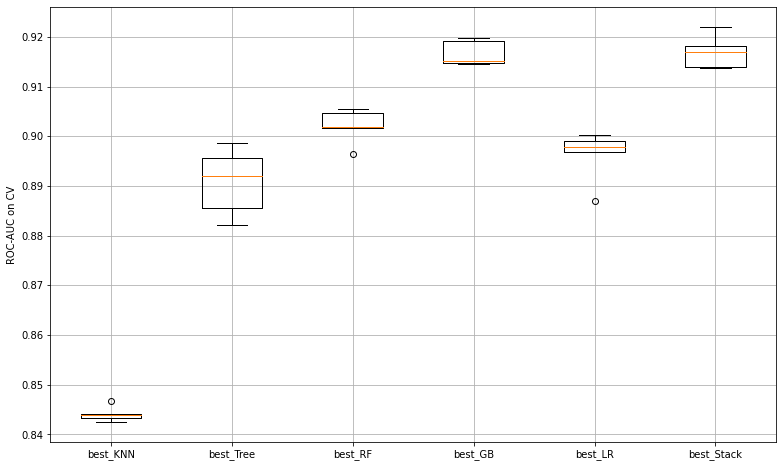

In [323]:
plt.figure(figsize=(13, 8))
plt.boxplot(x=[scores[0], scores[1], scores[2], scores[3], scores[4], scores_stack], labels=['best_KNN', 'best_Tree', 'best_RF', 'best_GB', 'best_LR', 'best_Stack'])
plt.ylabel("ROC-AUC on CV")
plt.grid(b=1)
plt.show()

**Вывод**:

1. KNN

Непараметрический метод (не обучает параметры, а просто запоминает выборку и по ней считает расстояния до новых объектов). Алгоритм является зависимым от масштаба признаков (причина описана в **Задание 6**). Скорость работы алгоритма около 8 секунд, что является вторым результатом после решающего дерева, но стоит отметить, что скорость предсказания алгоритма уменьшается с ростом количества признаков или объектов, так как приходится считать больше расстояний. Основные гиперпараметры - количество соседей (4) и метрика расчёта расстояний между соседями (manhattan). В конечном итоге алгоритм показал самое низкое качествое по кросс-валидации по 5 фолдам (auc-roc = 0.845).

2. DecesionTree

Дискретная модель (обучается путём подбора предикатов (лучший признак - лучший порог), постепенно разбивая элементы в вершинах до листьев). Алгоритм не зависит от масштаба признаков (причина описана в **Задание 6**). Скорость работы алгоритма около 4-5 секунд, что является самым быстрым результатом, что ожидаемо, учитывая ограничение на глубину дерева. Основные гиперпараметры - максимальная глубина дерева (7) и критерий информативности (entropy). При своей относительной простоте показал четвертое качество (auc-roc = 0.895), обогнав все классические модели, но уступив ансамблевым методам.

3. RandomForest

Композиция деревьев (в нашем случае, берётся 108 переобученных деревьев и происходит "голосование" за самый популярный класс). Алгоритм не зависит от масштаба признаков, поскольку строится на основе решающих деревьев, которые не зависят от масштаба. Скорость работы алгоритма около 50 секунд, что является самой быстрой среди других ансамблей, но сильно медленней чем у классических моделей. Основные гиперпараметры - количество деревьев (108), максимальное число признаков при выборе предиката (sqrt), критерий информативности (entropy). Алгоритм показал 2-3 результат, так как сложно сказать, результаты статистически не отличаются от стекинга (roc-auc = 0.9).

4. GradientBoosting

Композиция деревьев (в нашем случае, берутся деревья, каждое из которых обучается последовательно на основе предыдущих). Алгоритм не зависит от масштаба признаков, поскольку строится на основе решающих деревьев, которые не зависят от масштаба. Скорость работы алгоритма около 1260 секунд, что является самой медленной среди всех других моделей. Основные гиперпараметры - количество деревьев (300), максимальное число признаков при выборе предиката (log2), критерий информативности (friedman_mse). Алгоритм показал первый или второй лучший результат (roc-auc=0.915), поскольку статистически сложно заметить разницу между результатом градиентного бустинга и стекинга.

5. SGDClassifier

Логистическая регрессия (алгоритм, основанный на максимизации логарифма правдоподобия с сигмойдной функцией). Алгоритм зависит от масштаба признаков (причина описана в **Задание 6**). Скорость работы алгоритма около 10 секунд, то есть по скорости алгоритм находится в середине. Основные гиперпараметры - коэффициент регуляризации (0.0001), функция ошибок (в разных пунктах разная, но на масштабированных данных - log), вид регуляризации (l1). Алгоритм показал результат чуть ниже простого решающего дерева (roc-auc=0.89), при этом стоит отметить высокий разброс предсказаний алгоритма.

6. Stacking of RandomForest and GradientBoosting

Смешивание композиций деревьев (взяли предсказанные вероятности случайного леса и градиентного бустинга с некоторым весом). Алгоритм зависит от масштаба признаков, поскольку его производные алгоритмы тоже не зависят от масштаба. Скорость работы алгоритма оценить - примерно 535 + 50 секунд, поскольку надо учитывать время обучения каждого из производных алгоритмов. Основные гиперпараметры - все, которые относятся к случайному лесу и градиентному бустингу, а также параметр alpha - вес случайного леса в композиции. В результате получили, что стекинг моделей показал первый или второй лучший результат (roc-auc=0.915), но, что важно, алгоритм имеет меньший разброс относительно простого бустинга.